In [1]:
!pip install kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ivoryeee","key":"dab45a437222c368e54010f7be4ee4bb"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 99% 328M/331M [00:11<00:00, 30.1MB/s]
100% 331M/331M [00:11<00:00, 29.1MB/s]


In [4]:
!unzip utkface-new.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327523.jpg.chip.jp

In [5]:
#https://www.kaggle.com/mohamedahmedae/utkface-v2-gender-97-race-94-age-mae-0-05 코드 참고
# 필요한 라이브러리 IMPORT
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import seaborn as sns
import plotly.graph_objects as go


# 숫자로 표현되어있는 인종, 성별 데이터를 문자열로 변환해주기 위한 dictionary 생성
dataset_dict = {
    'race_id': {
        0: 'white',
        1: 'black',
        2: 'asian',
        3: 'indian',
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

folder_name = 'UTKFace'

In [6]:
def parse_dataset(dataset_path, ext='jpg'):

    def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None

    files = glob(os.path.join(dataset_path, "*.%s" % ext))

    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)

    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()

    return df

df = parse_dataset(folder_name)

df.head()

,age,gender,race,file
0,36.0,male,white,UTKFace/36_0_0_20170119201626207.jpg.chip.jpg
1,26.0,female,asian,UTKFace/26_1_2_20170116180523022.jpg.chip.jpg
2,36.0,male,indian,UTKFace/36_0_3_20170119202128525.jpg.chip.jpg
3,2.0,male,others,UTKFace/2_0_4_20161221202954025.jpg.chip.jpg
4,10.0,male,white,UTKFace/10_0_0_20170110225246490.jpg.chip.jpg


In [7]:
#MODEL 구축을 위한 라이브러리 import
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D, Activation, Dropout, Lambda, Dense, Flatten, Input
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as k

In [8]:
def load_and_preprocess_image(filepath, target_size=(200, 200)):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    return img

files = df['file'].tolist()
ages = df['age'].tolist()

images = [load_and_preprocess_image(file) for file in files[:1000]]  # 대용량 데이터를 한 번에 처리하지 않기 위해 일부만 사용
age = np.array(ages[:1000], dtype=np.int64)
images = np.array(images)

In [9]:
# images = []
# age = []
# for img in os.listdir(folder_name):
#   ages = img.split("_")[0]
#   img = cv2.imread(str(folder_name)+"/"+str(img))
#   img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#   img = img
#   images.append(np.array(img))
#   age.append(np.array(ages))

# age = np.array(age,dtype=np.int64)
# images = np.array(images)

In [10]:
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(images, age, random_state=42, test_size=0.4)
x_valid_age, x_test_age, y_valid_age, y_test_age = train_test_split(x_test_age, y_test_age, random_state=42, test_size = 0.5)

In [11]:

from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import EarlyStopping, ModelCheckpoint

init_lr = 1e-4
epochs = 50
batch_size = 16  # 메모리 문제가 발생하면 이 값을 줄이세요

# 과적합 방지를 위한 callback 설정
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint(filepath='./model-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', save_best_only=True)
]

# ExponentialDecay를 사용하여 학습률 감소 설정
lr_schedule = ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=epochs,  # decay_steps는 학습률이 감소되는 빈도를 의미
    decay_rate=0.96,     # decay_rate는 학습률이 줄어드는 비율을 의미
    staircase=True       # True로 설정하면 학습률이 계단식으로 감소
)

opt = Adam(learning_rate=lr_schedule)

In [12]:
!pip install keras_applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00


In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

# 데이터 증강
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# 사전 학습된 모델 불러오기 (VGG16)
base_model = VGG16(include_top=False, input_shape=(200, 200, 3))
base_model.trainable = False  # 학습되지 않도록 고정

# 모델 구성
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')
])

58889256/58889256 [==============================] - 2s 0us/step


In [14]:
model.compile(loss="mse", optimizer=opt, metrics=['mae'])

In [15]:
# 모델 학습
history = model.fit(
    datagen.flow(x_train_age, y_train_age, batch_size=batch_size),
    validation_data=(x_valid_age, y_valid_age),
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 582.1465 - mae: 18.7381

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 472s 12s/step - loss: 582.1465 - mae: 18.7381 - val_loss: 231.1700 - val_mae: 12.0578
Epoch 2/50
38/38 [==============================] - 470s 12s/step - loss: 286.2838 - mae: 12.7838 - val_loss: 213.5564 - val_mae: 11.4306
Epoch 3/50
38/38 [==============================] - 476s 13s/step - loss: 220.5753 - mae: 11.8137 - val_loss: 190.0011 - val_mae: 10.6354
Epoch 4/50
38/38 [==============================] - 473s 13s/step - loss: 182.8211 - mae: 10.5740 - val_loss: 196.4167 - val_mae: 10.9907
Epoch 5/50
38/38 [==============================] - 483s 13s/step - loss: 166.2130 - mae: 9.9294 - val_loss: 199.1318 - val_mae: 10.8247
Epoch 6/50
38/38 [==============================] - 436s 12s/step - loss: 146.9642 - mae: 9.4583 - val_loss: 195.2293 - val_mae: 10.8133
Epoch 7/50
38/38 [==============================] - 472s 12s/step - loss: 138.3821 - mae: 9.3281 - val_loss: 184.8321 - val_mae: 10.5707
Epoch 8/50
38/38 [==============================

In [16]:

# 모델 저장
model.save('age_model_vgg16.h5')

from google.colab import files
files.download('age_model_vgg16.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

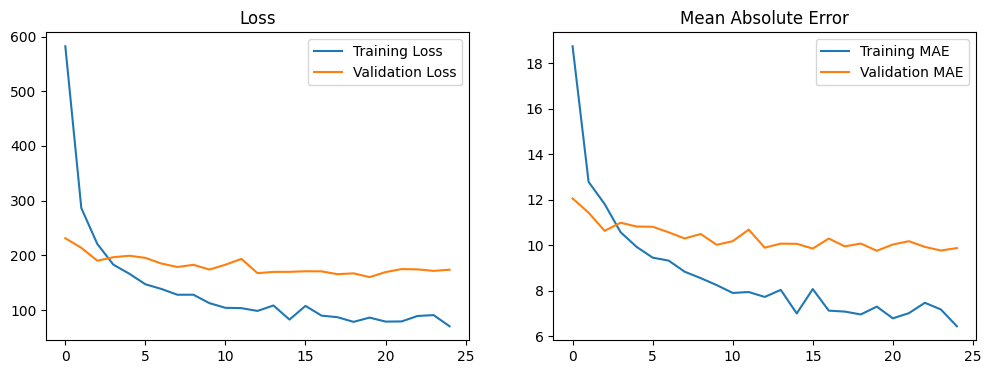

In [19]:
# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.title('Mean Absolute Error')

plt.show()

In [25]:
!pip install opencv-python

1/1 [==============================] - 1s 859ms/step


<ipython-input-36-e6f675799479>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.putText(pic, "Age:" + str(int(age_predict)), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)


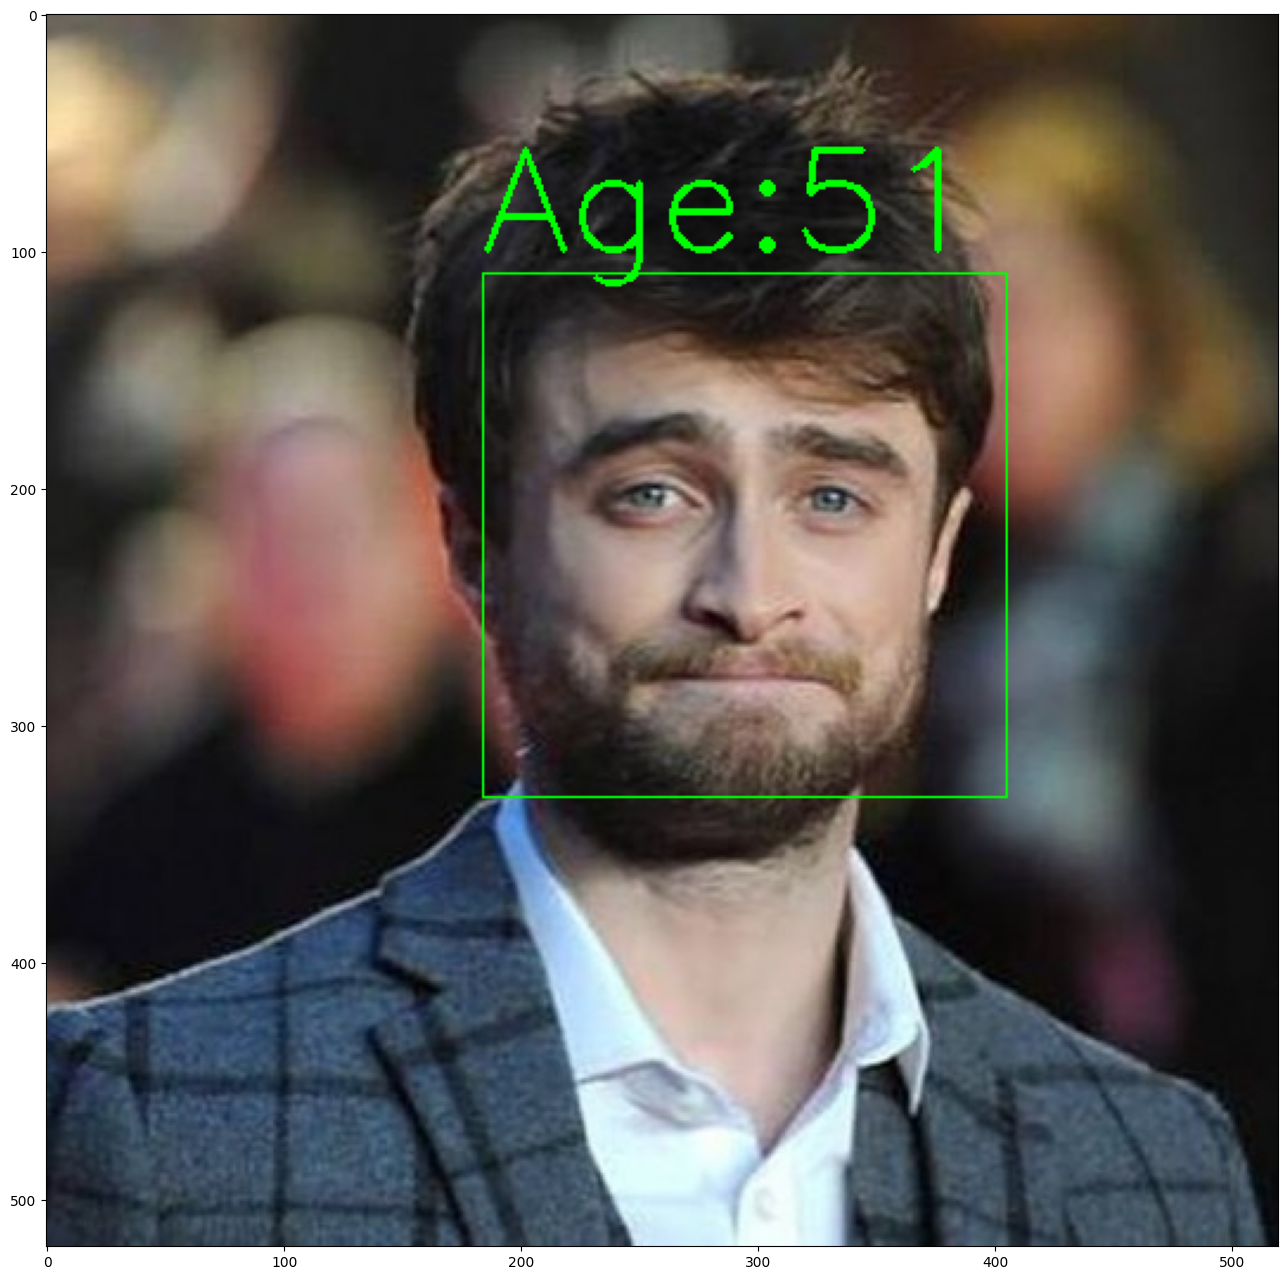

In [36]:
#라이브러리 import
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

#model load
age_model_vgg16_path = "./age_model_vgg16.h5"

age_model = load_model(age_model_vgg16_path)

#얼굴 검출을 위한 OPENCV Cascadeclassifier load
face_cascade = cv2.CascadeClassifier("./haarcascade_frontalface_default.xml")

age_ = []

image_size = 200


pic = cv2.imread('./4.jpg')
faces = face_cascade.detectMultiScale(pic, scaleFactor=1.11, minNeighbors=8)
age_ = []
for (x, y, w, h) in faces:
    img = pic[y:y + h, x:x + w]
    img = cv2.resize(img, (image_size, image_size))
    age_predict = age_model.predict(np.array(img).reshape(-1, image_size, image_size, 3))
    age_.append(age_predict)
    cv2.rectangle(pic, (x, y), (x + w, y + h), (0, 255, 0), 1)
    cv2.putText(pic, "Age:" + str(int(age_predict)), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
pic1 = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 16))
plt.imshow(pic1)